#  Внимание в задачах компьютерного зрения

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://arxiv.org/pdf/1807.06521
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%85%D0%B0%D0%BD%D0%B8%D0%B7%D0%BC_%D0%B2%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D1%8F
* https://github.com/luuuyi/CBAM.PyTorch
* https://arxiv.org/pdf/1506.01497

## Задачи для совместного разбора

1\. Обсудите концепцию внимания и варианты реализации применительно к задачам комьютерного зрения

## Задачи для самостоятельного решения

In [70]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import Adam
import torchvision
import torchvision.transforms.v2 as T
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from pytorch_lightning.loggers import MLFlowLogger
import subprocess
import mlflow
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Tuple, List
import os
from IPython.display import Image as dispImage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from torchvision.transforms.v2 import functional as T_F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import requests
from urllib.parse import urlparse
import zipfile

<p class="task" id="1"></p>

1\. Реализуйте простую версию пространственного внимания. Реализуйте сжатия карт признаков при помощи двух операций: average pooling по каналам и max pooling по каналам. Затем объедините эти два представления (вдоль оси каналов) и пропустите через небольшой сверточный слой, который и учится генерировать итоговую 2D-карту внимания.

Для генерации коэффициентов внимания используйте `nn.Conv2d` (2 входных канала, 1 выходной, ядро 7x7) и активацию `nn.Sigmoid`. Метод `forward` должен возвращать два тензора: исходные карты признаков и полученную карту внимания.

После создания класса проверьте его работоспособность. Создайте экземпляр модуля. Сгенерируйте случайный тензор, имитирующий выход сверточного слоя для одного изображения (например, с размерами (1, 64, 32, 32)). Пропустите этот тензор через ваш модуль и выведите на экран размеры входного тензора и итоговой карты внимания. Убедитесь, что карта внимания имеет один канал и те же пространственные размеры, что и вход.

- [x] Проверено на семинаре

In [71]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size:int = 7):
        super().__init__()
        
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2,1,kernel_size=kernel_size,padding=padding)
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        # x: [Batch, Channels, H, W]
        # Сжимаем каналы: [B, C, H, W] -> [B, 1, H, W]
        xmp,_ = torch.max(x,-3, keepdim=True)
        xav = torch.mean(x, -3, keepdim=True)    
        xcat = torch.cat([xmp,xav],1)
        xconv = self.conv(xcat)
        
        xatt = self.sigm(xconv)
        
        return x , xatt




x = torch.randn((1,64,32,32))

att =  SpatialAttention(7)
x , xatt = att(x)


x.shape, xatt.shape

(torch.Size([1, 64, 32, 32]), torch.Size([1, 1, 32, 32]))

<p class="task" id="2"></p>

2\. Создайте модель для классификации изображений с использованием разработанного механизма внимания. Добавьте после стандартного блока извлечения признаков (свертка-активация-пулинг) модуль внимания. Для применения механизма внимания умножьте выход последнего слоя на полученную карту внимания. После этого "выпрямите" тензор и передайте его в часть-классификатор. Метод forward должен возвращать два значения: логиты (выход классификатора) и карту внимания (понадобится для последующего анализа).

В качестве датасета используйте STL10 из `torchvision.datasets`. Обучите вашу модель на протяжении нескольких эпох (5-10). После обучения оцените точность модели на тестовой выборке.

- [ ] Проверено на семинаре

переделаем под тандартный вывод с forward'а

In [72]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        
        padding = (kernel_size - 1) // 2
        
        self.conv = nn.Conv2d(
            in_channels=2, 
            out_channels=1, 
            kernel_size=kernel_size, 
            padding=padding, 
            bias=False
        )
        self.sigm = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xmp, _ = torch.max(x, dim=1, keepdim=True)
        xav = torch.mean(x, dim=1, keepdim=True)
        xcat = torch.cat([xmp, xav], dim=1)
        xconv = self.conv(xcat)
        attn_map = self.sigm(xconv)
        
        return attn_map

In [73]:
def run_screenshot_script(url, output_path, width=1920, height=1480, sleep=5):
    """Запускает Playwright в подпроцессе для снятия скриншота."""
    script_code = """
import sys
import time
from playwright.sync_api import sync_playwright

def take_screenshot(url, output_path, width, height, sleep):
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            page = browser.new_page()
            page.set_viewport_size({"width": int(width), "height": int(height)})
            page.goto(url)
            time.sleep(int(sleep)) 
            page.screenshot(path=output_path, full_page=True)
            browser.close()
        print(f"Picture saved: {output_path}")
    except Exception as e:
        print(f"Error: {e}", file=sys.stderr)
        sys.exit(1)

if __name__ == "__main__":
    take_screenshot(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])
"""
    try:
        subprocess.run(
            [sys.executable, "-c", script_code, url, output_path, str(width), str(height), str(sleep)],
            capture_output=True, text=True, check=True
        )
        print(f"📸 Скриншот сохранен: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Ошибка скриншота:\n{e.stderr}", file=sys.stderr)



if 'mlflow_process' in locals() and mlflow_process.poll() is None:
    mlflow_process.terminate()
    mlflow_process.wait()

port = 5000
mlflow_tracking_uri = "file:./mlruns"
experiment_name = "Attention_Tries"

mlflow_process = subprocess.Popen(
    ["mlflow", "ui", "--port", str(port), "--backend-store-uri", mlflow_tracking_uri],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)
print(f"🚀 MLflow UI запущен на http://localhost:{port}")
print(f"PID: {mlflow_process.pid}")

# Настраиваем клиент
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)

🚀 MLflow UI запущен на http://localhost:5000
PID: 31484


<Experiment: artifact_location='file:c:/Projects/FU/Course_3/DL/mlruns/421506400009358912', creation_time=1765620233407, experiment_id='421506400009358912', last_update_time=1765620233407, lifecycle_stage='active', name='Attention_Tries', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [74]:
class AttentionClassifier(pl.LightningModule):
    def __init__(self, num_classes: int = 10, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        # STL10 картинки: 96x96
        self.features = nn.Sequential(
            # Block 1: [3, 96, 96] -> [32, 48, 48]
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2: [32, 48, 48] -> [64, 24, 24]
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3: [64, 24, 24] -> [128, 12, 12]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.spatial_attention = SpatialAttention(kernel_size=7)
        
        self.flatten_size = 128 * 12 * 12

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.f1score = F1Score(task="multiclass", num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        features = self.features(x) # [B, 128, 12, 12]
        attn_map = self.spatial_attention(features) # [B, 1, 12, 12]
        
        # [B, 128, 12, 12] * [B, 1, 12, 12] -> [B, 128, 12, 12]
        attended_features = features * attn_map 
        logits = self.classifier(attended_features) # [B, num_classes]

        return logits, attn_map

    # Вспомогательная функция для логирования
    def _step(self, batch: Tuple[torch.Tensor, torch.Tensor], stage: str) -> torch.Tensor:
        x, y = batch
        logits, _ = self(x)
        
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits, y)
        f1 = self.f1score(logits,y)
        
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", acc, prog_bar=True)
        self.log(f"{stage}_f1", f1, prog_bar=True)
        
        return loss

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        return self._step(batch, "train")

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        self._step(batch, "val")

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        self._step(batch, "test")

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.hparams.lr)

In [75]:
class STL10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir='./data', batch_size=64, val_size=0.2, seed=42):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_size = val_size
        self.seed = seed
        
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ])

    def prepare_data(self):
        torchvision.datasets.STL10(self.data_dir, split='train', download=True)
        torchvision.datasets.STL10(self.data_dir, split='test', download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            full_train_dataset = torchvision.datasets.STL10(
                self.data_dir, split='train', transform=self.transform
            )
            targets = full_train_dataset.labels
            indices = np.arange(len(full_train_dataset))
            
            train_idx, val_idx = train_test_split(
                indices,
                test_size=self.val_size,
                shuffle=True,
                stratify=targets, 
                random_state=self.seed
            )
            
            self.train_ds = Subset(full_train_dataset, train_idx)
            self.val_ds = Subset(full_train_dataset, val_idx)

        if stage == 'test' or stage is None:
            self.test_ds = torchvision.datasets.STL10(
                self.data_dir, split='test', transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=8, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=8, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=8, persistent_workers=True)

In [76]:
MAX_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3
NUM_CLASSES=10

data_module = STL10DataModule(batch_size=BATCH_SIZE)
model = AttentionClassifier(num_classes=NUM_CLASSES, lr=LR)

mlf_logger = MLFlowLogger(
    experiment_name="Attention_Tries",
    tracking_uri="file:./mlruns"
)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=mlf_logger,
    accelerator="auto",
    devices=1,
    log_every_n_steps=10
)

trainer.fit(model, data_module)
trainer.test(model, data_module)

c:\Projects\FU\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | features          | Sequential         | 93.2 K | train
1 | spatial_attention | SpatialAttention   | 98     | train
2 | classifier        | Sequential         | 9.4 M  | train
3 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5888749957084656     │
│          test_f1          │    0.5888749957084656     │
│         test_loss         │     1.513298511505127     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.513298511505127,
  'test_acc': 0.5888749957084656,
  'test_f1': 0.5888749957084656}]

📸 Скриншот сохранен: images/run_metrics_60fac007868240e881b5783b4de0040c.png


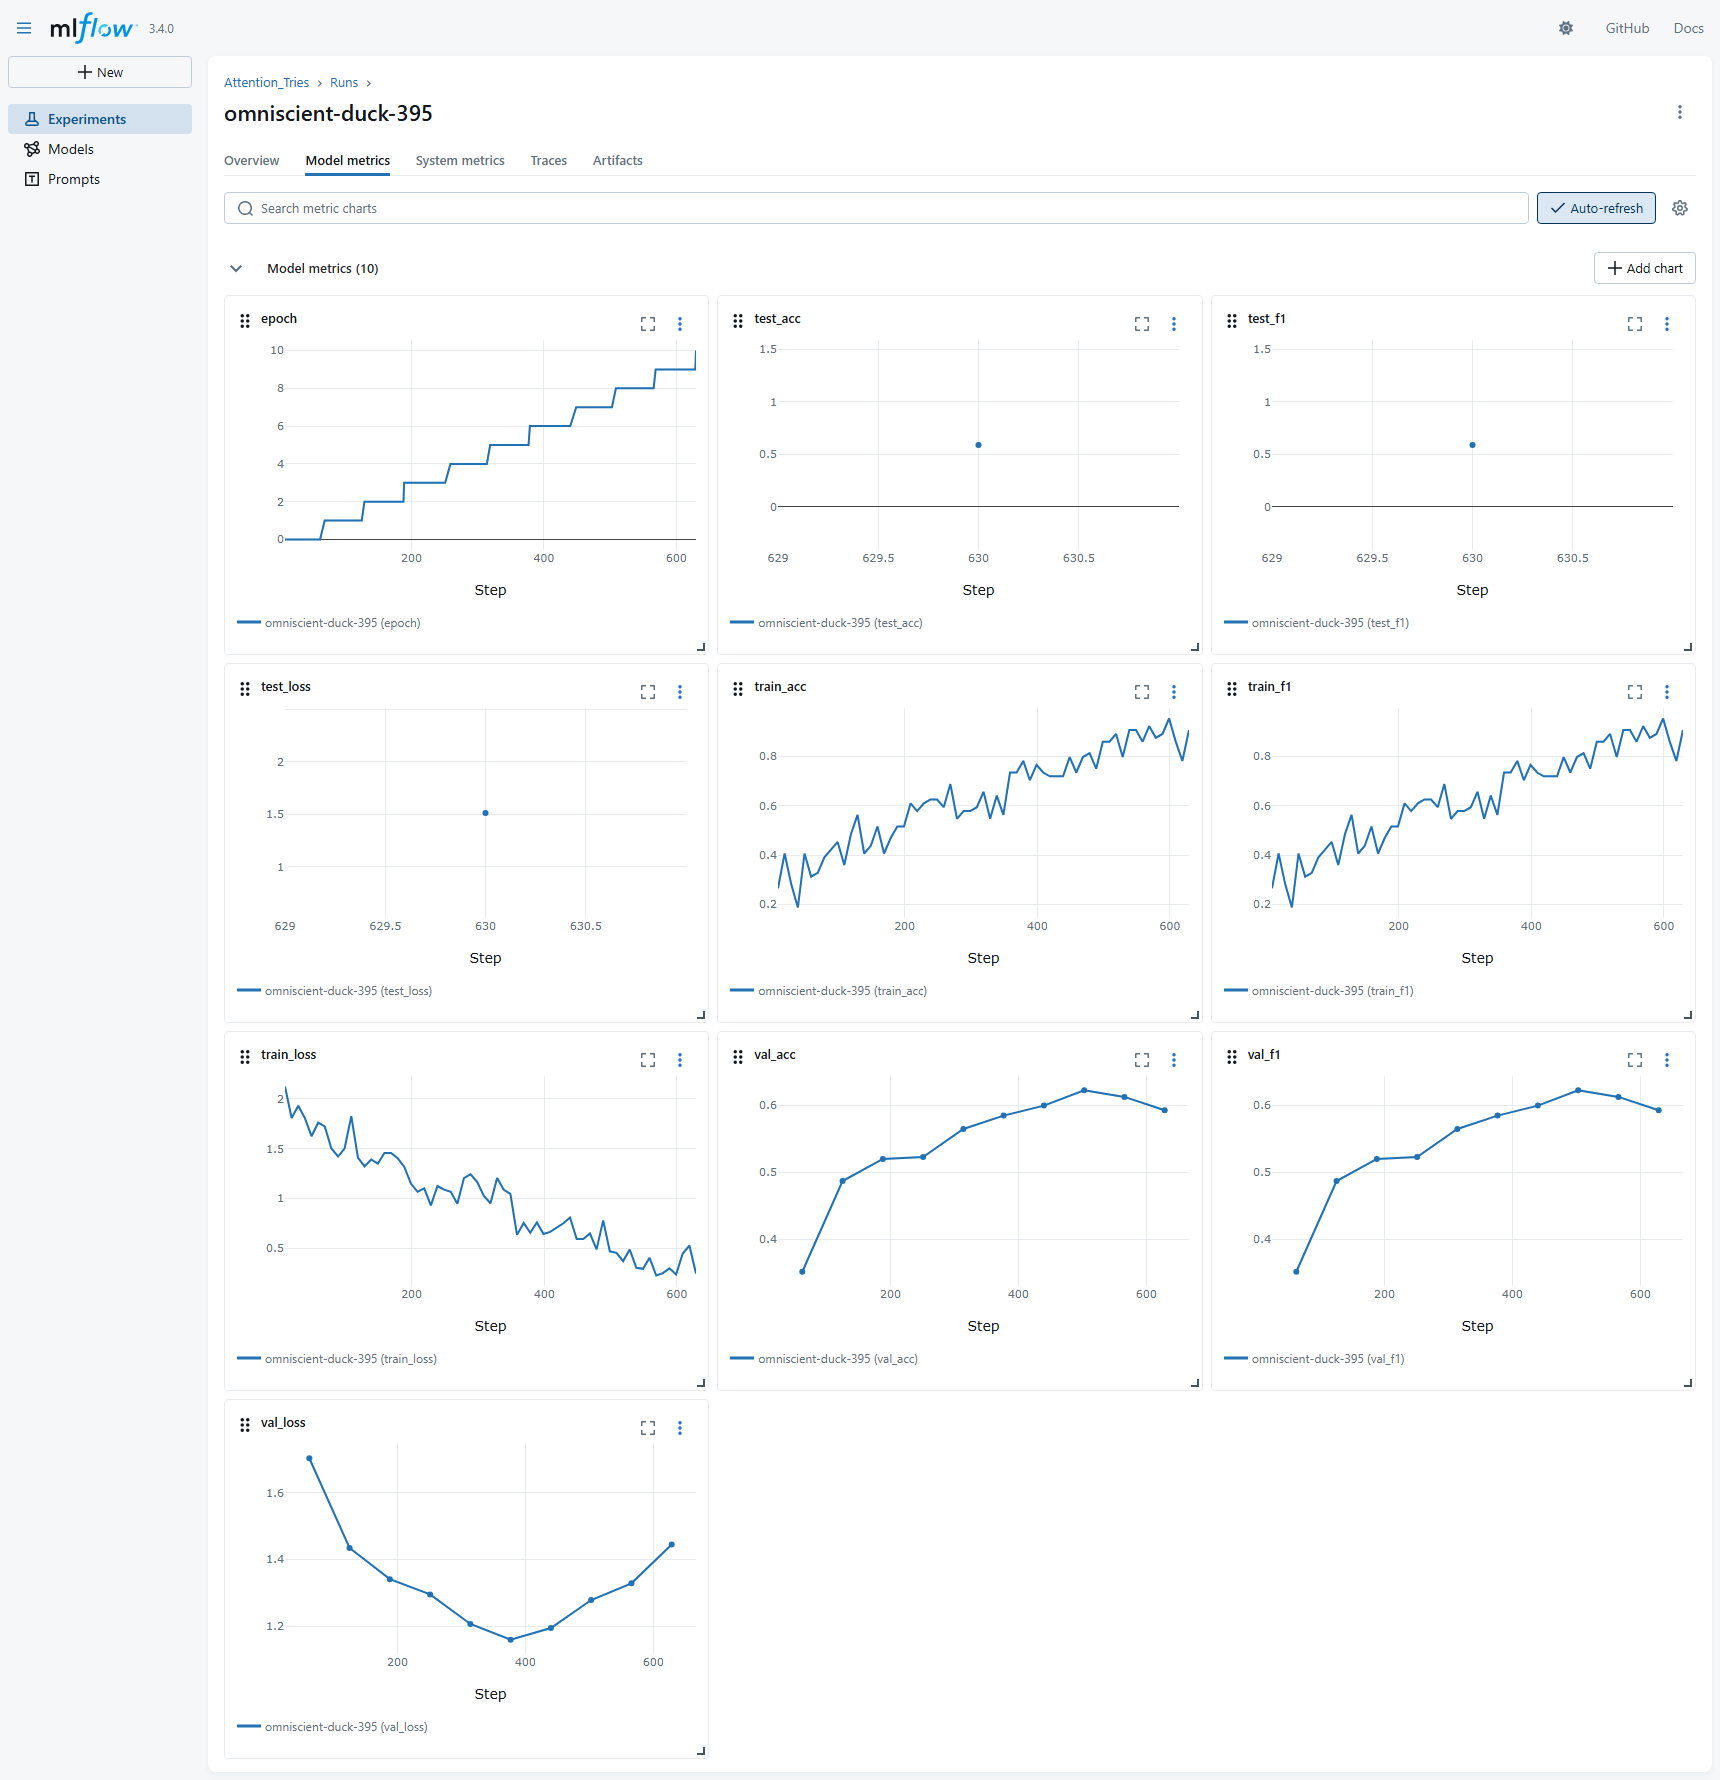

📸 Скриншот сохранен: images/main_60fac007868240e881b5783b4de0040c.png


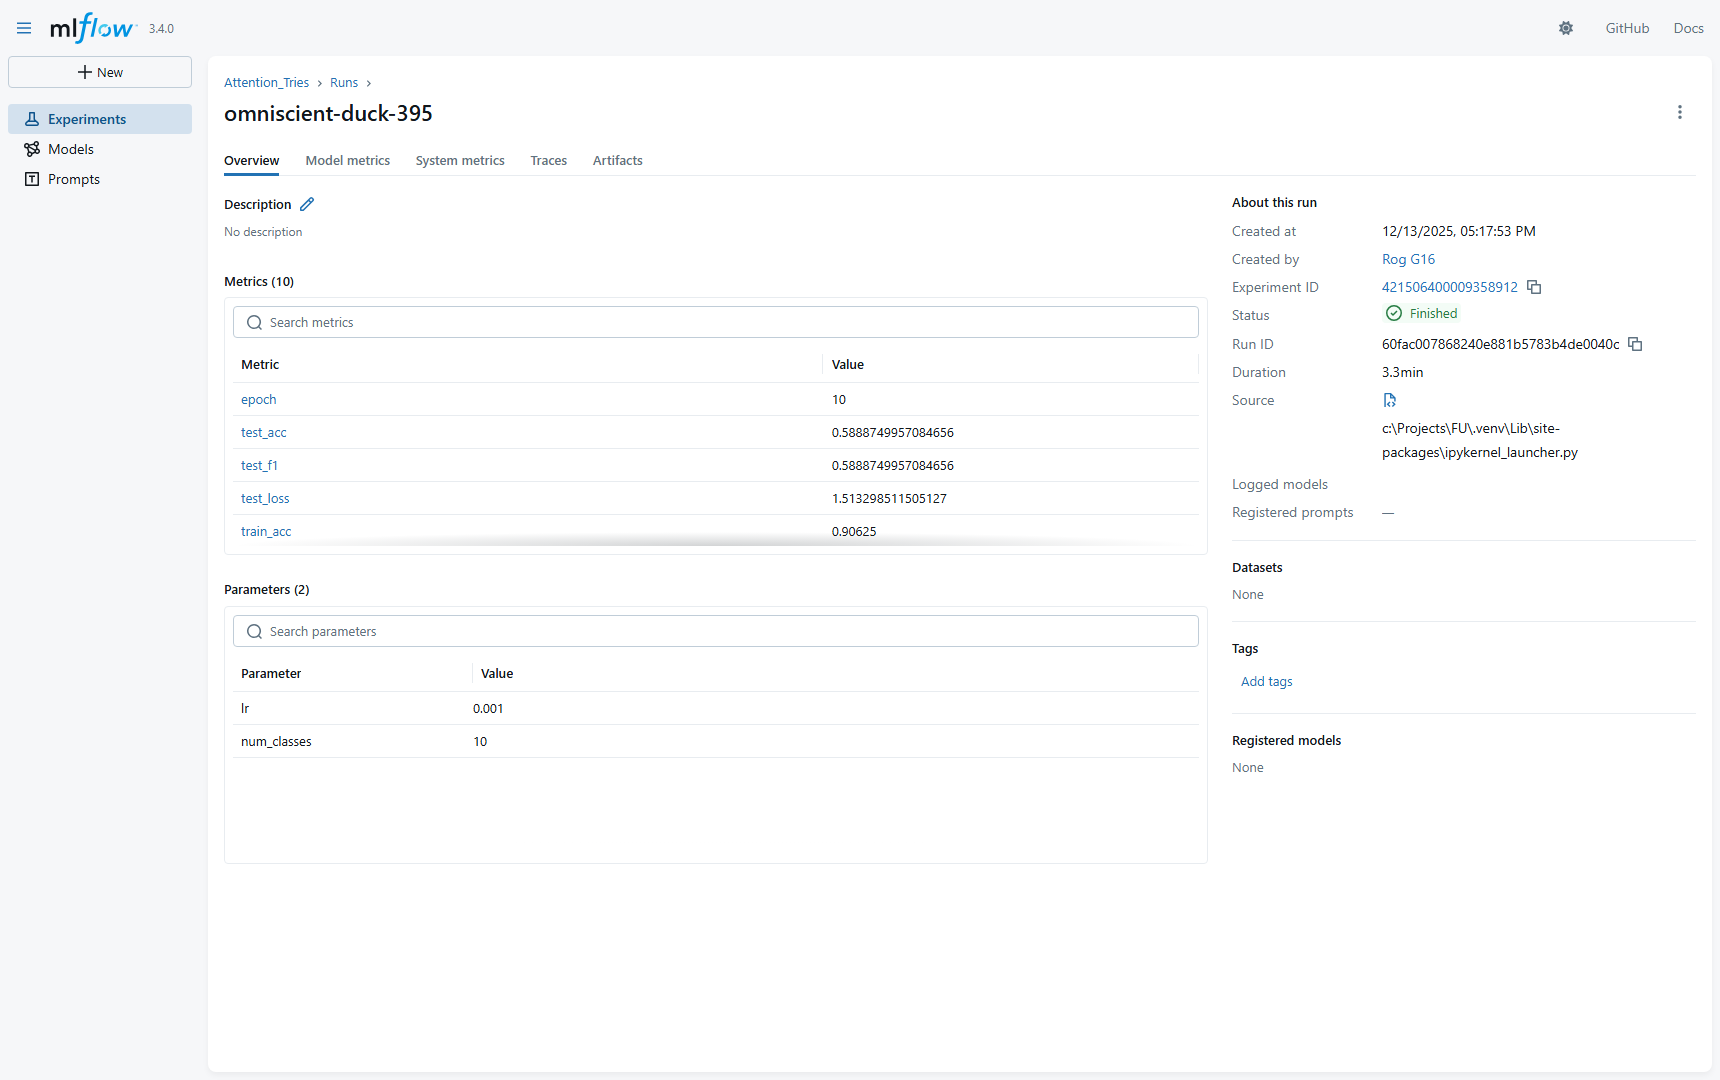

In [77]:
runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id])
id = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id]).dropna().index[0]
run_id = runs.iloc[id].run_id
experiment_id = runs.iloc[id].experiment_id


run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}"

os.makedirs("images", exist_ok=True)
screenshot_path = f"images/run_metrics_{run_id}.png"

try:
    target_url = run_url + "/model-metrics" 
    run_screenshot_script(target_url, screenshot_path, 1720, 1780, 5)
    
    display(dispImage(filename=screenshot_path))
except Exception as e:
    print(f"Could not display screenshot: {e}")
    
screenshot_path = f"images/main_{run_id}.png"

try:
    target_url = run_url 
    run_screenshot_script(target_url, screenshot_path, 1720, 1080, 5)
    
    display(dispImage(filename=screenshot_path))
except Exception as e:
    print(f"Could not display screenshot: {e}")

<p class="task" id="3"></p>

3\. Найдите два примера из тестовой части: один, где модель дала верный ответ, и второй, где она ошиблась. Для каждого из этих двух случаев получите от модели предсказание и карту внимания для выбранного изображения. Увеличьте размер карты внимания до размера исходного изображения с помощью `F.interpolate`, используя билинейный режим (`mode='bilinear'`).
Визуализируйте результат: слева — исходное изображение, справа — его карта внимания. Подпишите каждое изображение его истинным классом и предсказанием модели.

- [ ] Проверено на семинаре

In [78]:
STL10_CLASSES = [
    'airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'
]

def denormalize_image(tensor: torch.Tensor, mean: Tuple[float], std: Tuple[float]) -> np.ndarray:
    img_np = tensor.cpu().numpy().transpose(1, 2, 0)
    
    mean_np = np.array(mean)
    std_np = np.array(std)
    img_np = (img_np * std_np) + mean_np

    img_np = np.clip(img_np, 0, 1)
    
    return img_np

In [79]:
data_module.prepare_data()
data_module.setup(stage='test')

model.eval() 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

AttentionClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (spatial_attention): SpatialAttention(
    (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigm): Sigmoid()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18432, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
  (accuracy): M

In [80]:
test_dataloader = data_module.test_dataloader()
results = []
test_data_count = 0

with torch.no_grad():
    for batch_idx, (x, y) in tqdm(enumerate(test_dataloader)):
        x = x.to(device)
        y = y.to(device)
        
        logits, attn_map = model(x)
        
        preds = torch.argmax(logits, dim=1)
        
        for i in range(x.size(0)):
            results.append({
                'image': x[i].cpu(),             # [C, H, W]
                'true_label': y[i].item(),
                'pred_label': preds[i].item(),
                'attn_map': attn_map[i].cpu()    # [1, H_small, W_small]
            })
            test_data_count += 1

0it [00:00, ?it/s]

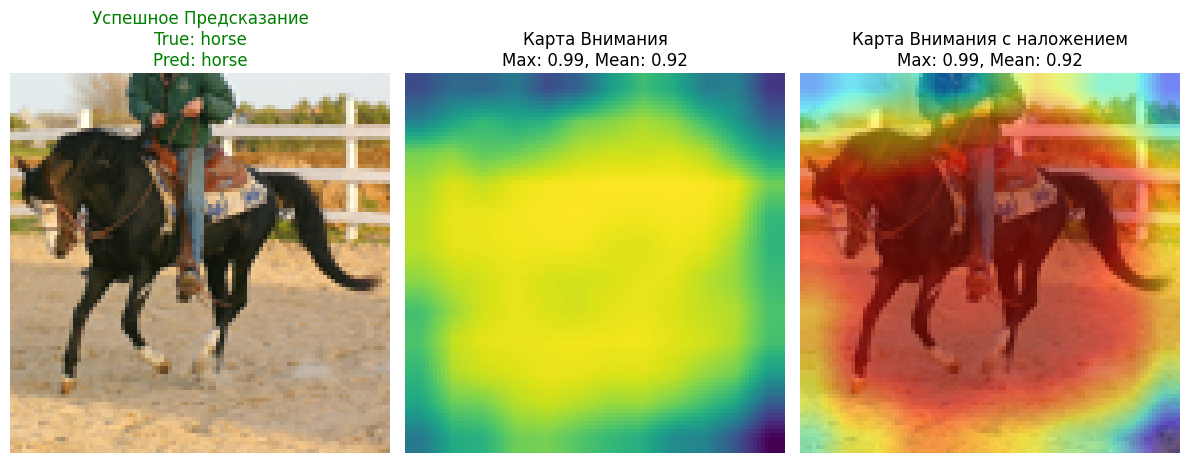

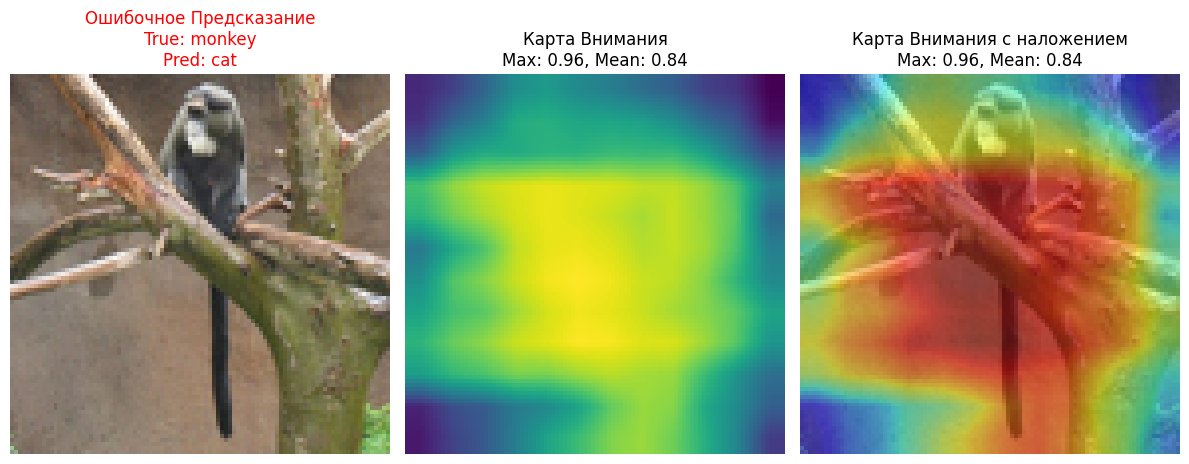

In [81]:
success_example = None
error_example = None

for res in results:
    is_correct = (res['true_label'] == res['pred_label'])
    
    if is_correct and success_example is None:
        success_example = res
    elif not is_correct and error_example is None:
        error_example = res
        
    if success_example and error_example:
        break


def visualize_attention(res: dict, title_prefix: str):
    img_tensor = res['image'] # [C, H, W]
    attn_map_tensor = res['attn_map'] # [1, H_small, W_small]
    
    original_h, original_w = img_tensor.shape[1:]
    
    attn_map_4D = attn_map_tensor.unsqueeze(0) 
    
    upsampled_attn = F.interpolate(
        attn_map_4D, 
        size=(original_h, original_w), 
        mode='bilinear', 
        align_corners=False
    )
    
    upsampled_attn = upsampled_attn.squeeze(0) 
    
    img_denorm = denormalize_image(img_tensor, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
    attn_map_np = upsampled_attn.squeeze(0).numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    
    axes[0].imshow(img_denorm)
    axes[0].set_title(
        f"{title_prefix}\nTrue: {STL10_CLASSES[res['true_label']]}\nPred: {STL10_CLASSES[res['pred_label']]}", 
        fontsize=12,
        color='green' if res['true_label'] == res['pred_label'] else 'red'
    )
    axes[0].axis('off')
    
    
    axes[1].imshow(attn_map_np, cmap='viridis') 
    axes[1].set_title(
        f"Карта Внимания\nMax: {attn_map_np.max():.2f}, Mean: {attn_map_np.mean():.2f}", 
        fontsize=12
    )
    axes[1].axis('off')
    


    axes[2].imshow(attn_map_np, cmap='viridis')
    axes[2].set_title(
        f"Карта Внимания с наложением\nMax: {attn_map_np.max():.2f}, Mean: {attn_map_np.mean():.2f}", 
        fontsize=12
    )
    axes[2].axis('off')
    
    axes[2].imshow(img_denorm)
    axes[2].imshow(attn_map_np, cmap='jet', alpha=0.5)


    plt.tight_layout()
    plt.show()

visualize_attention(success_example, "Успешное Предсказание")

visualize_attention(error_example, "Ошибочное Предсказание")

<p class="task" id="2"></p>

4\. Создайте класс `PennFudanDataset` для задачи предсказания объектов на изображениях пешеходов и их маски из датасета Penn-Fudan Pedestrian. Внутри класса преобразуйте маски в координаты ограничивающих рамок (bounding boxes) и метки классов.

Загрузите предобученную модель `fasterrcnn_resnet50_fpn` из `torchvision.models.detection`. Замените голову, решающую задачу предсказания. Создайте новый `FastRCNNPredictor` для двух классов (num_classes = 2) и присвойте его атрибуту `model.roi_heads.box_predictor`.

Выполните обучение модели на созданном датасете. Для демонстрации работоспособности подхода достаточно одной эпохи (при необходимости можете обучить дольше).

- [ ] Проверено на семинаре

In [82]:
PENN_FUDAN_DIR = './data/PennFudanPed/PennFudanPed'

class PennFudanDataset(torch.utils.data.Dataset):
    """
    Датасет Penn-Fudan Pedestrian для обнаружения объектов.
    """
    def __init__(self, root: str, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, dict]:
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)[1:]
        
        masks = mask == obj_ids[:, None, None] # [num_objects, H, W]

        num_objs = len(obj_ids)
        if num_objs == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32) # [0, 4]
            labels = torch.zeros((0,), dtype=torch.int64) # [0]
            masks = torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8) # [0, H, W]
        else:
            masks = mask == obj_ids[:, None, None] # [num_objects, H, W]
            
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                # x_min, y_min, x_max, y_max
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64) 
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            
        if self.transforms:
            img, boxes = self.transforms(img, boxes)
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        img = T_F.to_tensor(img)

        return img, target


def collate_fn(batch: List[Tuple[torch.Tensor, dict]]) -> Tuple[List[torch.Tensor], List[dict]]:
    return tuple(zip(*batch))

In [83]:
def get_detection_model(num_classes: int):
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

model = get_detection_model(num_classes=2)

In [84]:
class FasterRCNNLightning(pl.LightningModule):
    def __init__(self, num_classes: int, lr: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = get_detection_model(num_classes)

    def forward(self, imgs: List[torch.Tensor], targets: List[dict] = None):
        self.model.eval()
        if self.training and targets is not None:
            self.model.train() 
            return self.model(imgs, targets)
        else:
            return self.model(imgs)

    def training_step(self, batch: Tuple[List[torch.Tensor], List[dict]], batch_idx: int):
        imgs, targets = batch
        loss_dict = self(imgs, targets) 
        
        loss = sum(loss for loss in loss_dict.values())
        
        self.log_dict(
            {"train_loss": loss, **{f"train_{k}": v for k, v in loss_dict.items()}},
            prog_bar=True, on_step=True, on_epoch=True
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(), 
            lr=self.hparams.lr, 
            momentum=0.9, 
            weight_decay=0.0005
        )
        return optimizer

In [85]:
def download_from_url(url: str, dest_folder: str, chunk_size=8192):
    """
    Скачивает файл с URL-адреса в указанную локальную папку с отображением прогресса через tqdm.

    :param url: URL-адрес файла для скачивания.
    :param dest_folder: Путь к папке, куда будет сохранен файл (относительный или абсолютный).
    :param chunk_size: Размер части данных для потоковой записи (в байтах).
    :return: Полный путь к скачанному файлу или None в случае ошибки.
    """
    try:
        parsed_url = urlparse(url)
        filename = os.path.basename(parsed_url.path)

        if not filename:
             print(f"Ошибка: Не удалось извлечь имя файла из URL: {url}")
             return None

        os.makedirs(dest_folder, exist_ok=True)

        file_path = os.path.join(dest_folder, filename)

        print(f"Начинается скачивание: {url}")
        print(f"Сохранение в: {os.path.abspath(file_path)}")
        with requests.get(url, stream=True) as response:
            if response.status_code == 200:
                total_size = int(response.headers.get('content-length', 0))
                
                with open(file_path, 'wb') as f:
                    with tqdm(
                        total=total_size, 
                        unit='B', 
                        unit_scale=True, 
                        desc=filename,
                    ) as pbar:
                        for chunk in response.iter_content(chunk_size=chunk_size):
                            if chunk:
                                f.write(chunk)
                                pbar.update(len(chunk))
                
                print(f"✅ Скачивание завершено: {file_path}")
                return file_path
            else:
                print(f"❌ Ошибка скачивания. Код статуса HTTP: {response.status_code}")
                print(f"Сообщение: {response.reason}")
                return None

    except requests.exceptions.RequestException as e:
        print(f"❌ Ошибка сетевого запроса: {e}")
        return None
    except Exception as e:
        print(f"❌ Произошла непредвиденная ошибка: {e}")
        return None

In [86]:
# target_url = r'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
# target_folder = 'data'

# downloaded_file = download_from_url(target_url, target_folder)

# if downloaded_file:
#     print(f"\nПуть к скачанному файлу: {downloaded_file}")

In [87]:
# def prepare_data(data_path, zip_path):
#     if not os.path.exists(data_path):
#         print(f"Распаковка архива {zip_path}...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(data_path)
#         print("Архив успешно распакован.")
#     else:
#         print(f"Директория {data_path} уже существует.")
    
# prepare_data('data\PennFudanPed',downloaded_file)

In [88]:
dataset = PennFudanDataset(PENN_FUDAN_DIR)

torch.manual_seed(42)
indices = torch.randperm(len(dataset)).tolist()
train_split = int(0.8 * len(dataset))

train_ds = torch.utils.data.Subset(dataset, indices[:train_split])
val_ds = torch.utils.data.Subset(dataset, indices[train_split:])

train_dataloader = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=4,
    shuffle=True, 
    num_workers=0,
    collate_fn=collate_fn
)
val_dataloader = torch.utils.data.DataLoader(
    val_ds, 
    batch_size=2, 
    shuffle=False, 
    num_workers=0,
    collate_fn=collate_fn
)

lightning_model = FasterRCNNLightning(num_classes=2, lr=0.005)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="auto", 
    devices=1,
    log_every_n_steps=1
)

trainer.fit(
    lightning_model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 41.3 M | train
---------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.p

Training: |          | 0/? [00:00<?, ?it/s]

c:\Projects\FU\.venv\Lib\site-packages\torchvision\transforms\v2\functional\_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=1` reached.


In [89]:
def plot_detection_results(
    img_tensor: torch.Tensor, 
    boxes: torch.Tensor, 
    labels: torch.Tensor,
    scores: torch.Tensor,
    score_threshold: float = 0.5,
    title: str = "Faster R-CNN Predictions (Score > 0.5)"
):

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    img_np = (img_np * 255).astype(np.uint8)
    
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img_np)
    ax.set_title(title)
    
    keep = scores > score_threshold
    filtered_boxes = boxes[keep].cpu().numpy()
    filtered_labels = labels[keep].cpu().numpy()
    filtered_scores = scores[keep].cpu().numpy()
    
    for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
        xmin, ymin, xmax, ymax = box
        
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor='red', 
            linewidth=2
        )
        ax.add_patch(rect)
        
        label_text = f"Pedestrian: {score:.2f}" # Класс 1 - Пешеход
        ax.text(
            xmin+3, ymin - 5, 
            label_text, 
            color='red', 
            fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        
    ax.axis('off')
    plt.show()

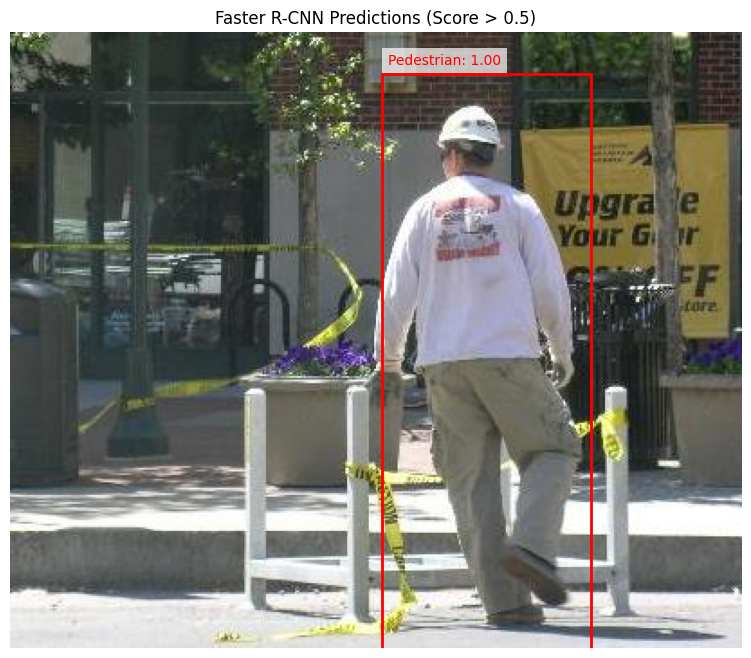

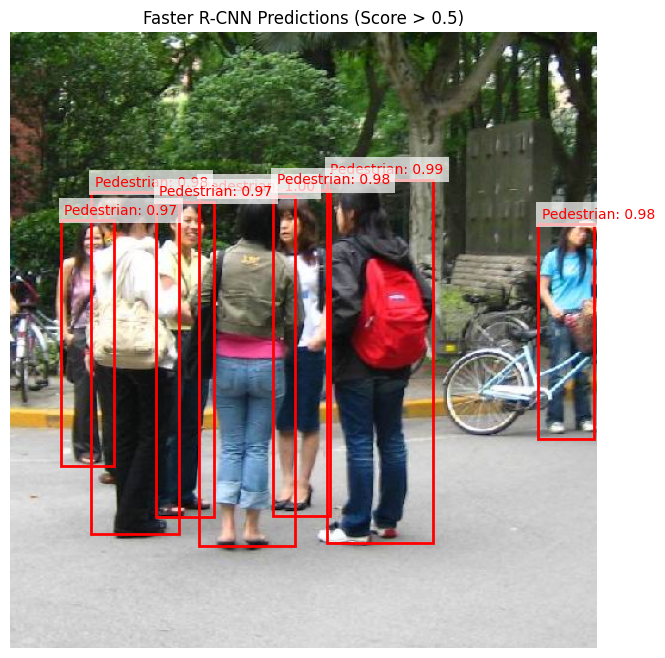

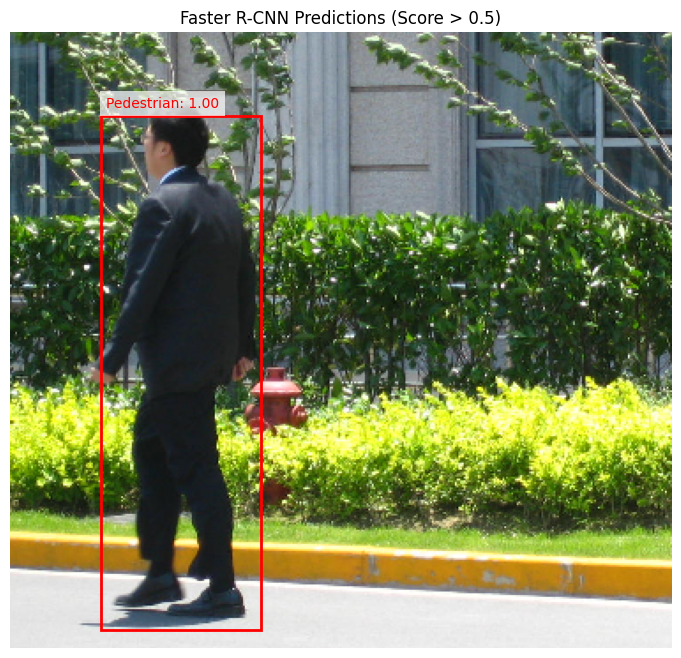

In [90]:
for sample_idx in  np.random.choice(range(len(val_ds)), (3,)):
    sample_img_tensor, sample_target = val_ds[sample_idx]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    lightning_model.to(device)
    lightning_model.eval() 

    input_img = [sample_img_tensor.to(device)]

    with torch.no_grad():
        predictions = lightning_model(input_img)

    pred = predictions[0]

    plot_detection_results(
        sample_img_tensor, 
        pred['boxes'], 
        pred['labels'], 
        pred['scores'],
        score_threshold=0.7 
    )

<p class="task" id="5"></p>


5\. В случае Faster R-CNN Region Proposal Network (RPN) выполняет роль механизма неявного внимания. Визуализируйте работу RPN на одном из изображений из датасета. Для этого потребуется вручную воспроизвести шаги прямого прохода модели, чтобы извлечь промежуточные данные (функция `get_proposals`).

Визуализируйте изображение с двумя наборами рамок:
- красным: несколько наиболее уверенных предложений от RPN
- зеленым: предсказанные bounding box модели с высоким порогом уверенности

- [ ] Проверено на семинаре

In [91]:
def plot_rpn_vs_final(
    img_tensor: torch.Tensor, 
    rpn_boxes: torch.Tensor, 
    final_pred: dict,
    num_rpn_to_show: int = 50,
    final_score_threshold: float = 0.7
):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img_np)
    ax.set_title(
        f"RPN Proposals (Красный) vs. Final BBoxes (Зеленый, Score > {final_score_threshold})",
        fontsize=14
    )
    
    rpn_boxes_np = rpn_boxes[:num_rpn_to_show].numpy()
    
    for box in rpn_boxes_np:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor='red', 
            linestyle='--',
            linewidth=1,
            alpha=0.8
        )
        ax.add_patch(rect)
        
    final_scores = final_pred['scores'].cpu()
    final_boxes = final_pred['boxes'].cpu()
    
    keep = final_scores > final_score_threshold
    final_boxes_np = final_boxes[keep].numpy()
    final_scores_np = final_scores[keep].numpy()
    
    for box, score in zip(final_boxes_np, final_scores_np):
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor='green', 
            linewidth=3,
        )
        ax.add_patch(rect)
        
        label_text = f"Pred: {score:.2f}"
        ax.text(
            xmin, ymax + 15, 
            label_text, 
            color='green', 
            fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        
    ax.axis('off')
    plt.show()


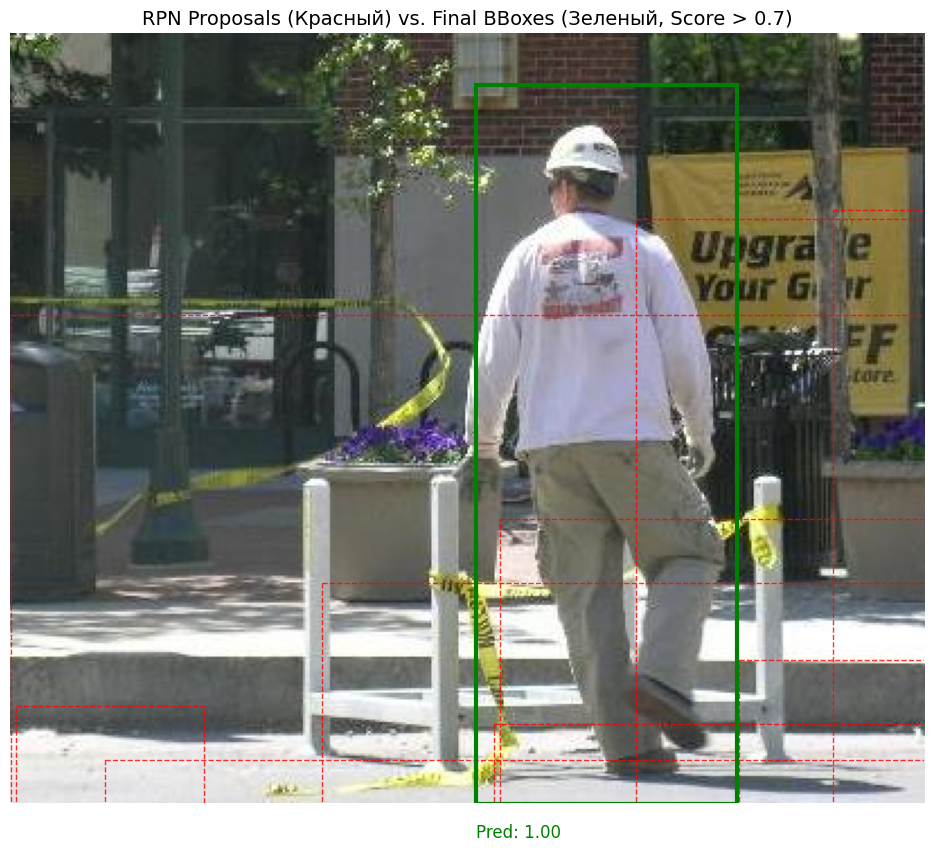

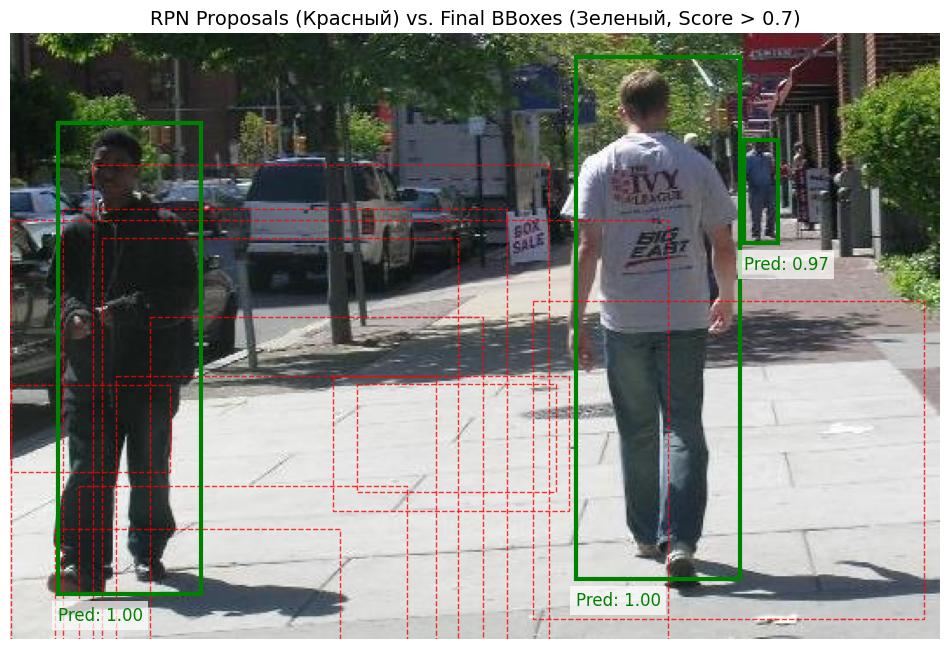

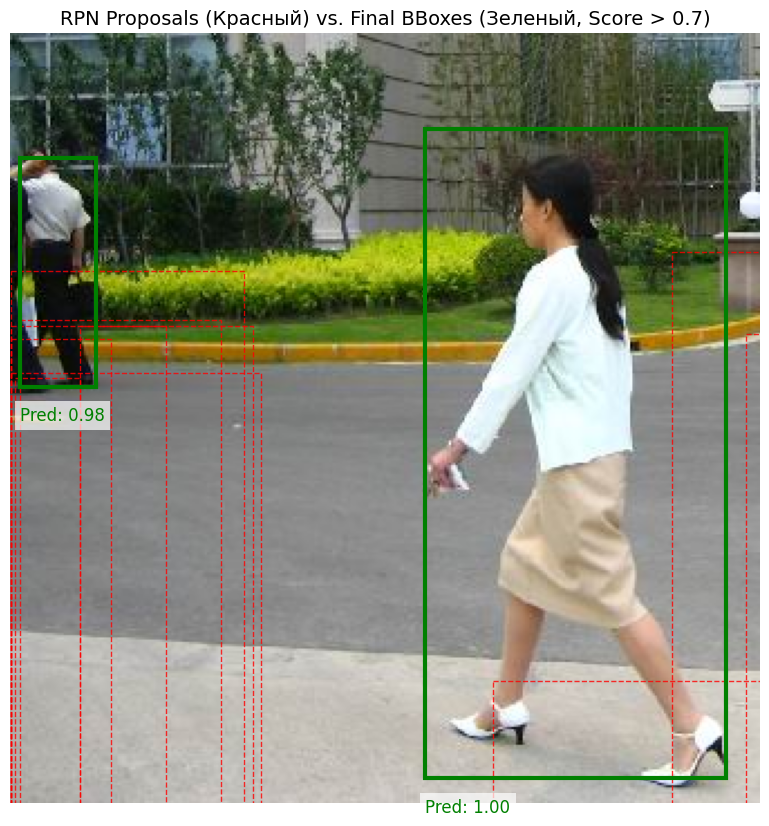

In [93]:
for sample_idx in np.random.choice(range(len(val_ds)), (3,)):
    sample_img_tensor, sample_target = val_ds[sample_idx]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    input_img = [sample_img_tensor.to(device)]

    lightning_model.to(device)
    lightning_model.eval()
    model = lightning_model.model

    with torch.no_grad():
        images, _ = model.transform(input_img)
        features = model.backbone(images.tensors)
        proposals, _ = model.rpn(images, features)
        
    rpn_proposals = proposals[0].cpu() # [N, 4] - координаты рамок

    with torch.no_grad():
        predictions = model(input_img)
    pred = predictions[0]





    plot_rpn_vs_final(
        sample_img_tensor, 
        rpn_proposals, 
        pred,
        num_rpn_to_show=20,         
        final_score_threshold=0.7    
    )